In [757]:
%matplotlib inline
import os
import regex
import random
import itertools
import pymystem3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import BallTree
from unionfind.unionfind import UnionFind
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

Using TensorFlow backend.


In [3]:
%time embeddings = KeyedVectors.load_word2vec_format("ruwikiruscorpora_0_300_20.bin", binary=True)

CPU times: user 8.19 s, sys: 406 ms, total: 8.6 s
Wall time: 8.61 s


In [935]:
stemmer = pymystem3.Mystem()

In [936]:
mystem_to_uni_str = """
A       ADJ
ADV     ADV
ADVPRO  ADV
ANUM    ADJ
APRO    DET
COM     ADJ
CONJ    SCONJ
INTJ    INTJ
NONLEX  X
NUM     NUM
PART    PART
PR      ADP
S       NOUN
SPRO    PRON
UNKN    X
V       VERB
"""

mystem_to_uni_map = dict(map(str.split, mystem_to_uni_str.strip().split("\n")))

In [937]:
token_regexp = regex.compile("(?u)\\b\\p{L}+\\b")

In [938]:
stemmer.analyze("умерла от рака кек 228 .")[::2]

[{'analysis': [{'gr': 'V,нп=прош,ед,изъяв,жен,сов', 'lex': 'умирать'}],
  'text': 'умерла'},
 {'analysis': [{'gr': 'PR=', 'lex': 'от'}], 'text': 'от'},
 {'analysis': [{'gr': 'S,муж,неод=род,ед', 'lex': 'рак'}], 'text': 'рака'},
 {'analysis': [{'gr': 'S,гео,муж,неод=(вин,ед|им,ед)',
    'lex': 'кек',
    'qual': 'bastard'}],
  'text': 'кек'},
 {'text': '228'},
 {'text': '.'}]

In [939]:
def tokenize(text):
    return token_regexp.findall(text.lower())

add_unparsed = True
gr_regexp = regex.compile("[^\w]")

def lemmatize(tokens):
    lemmas = []
    tokens_str = " ".join(tokens)
    for res in stemmer.analyze(tokens_str)[::2]:
        if res.get("analysis"):
            info = res["analysis"][0]
            stem_pos, *_ = gr_regexp.split(info["gr"].upper())
            lemmas.append("%s_%s" % (info["lex"], mystem_to_uni_map.get(stem_pos, "X")))
        elif add_unparsed:
            lemmas.append(res["text"])
    return lemmas

In [283]:
lemmatize(tokenize("У Антона очень красивый ноутбук.\n\n"))

['у_ADP', 'антон_NOUN', 'очень_ADV', 'красивый_ADJ', 'ноутбук_NOUN']

## Метрики

In [662]:
from scipy.spatial.distance import cosine

In [10]:
def jaccard_lemmas(susp_lemmas, src_lemmas):
    if len(susp_lemmas) and len(src_lemmas):
        s1, s2 = set(susp_lemmas), set(src_lemmas)
        return 1 - len(s1 & s2) / len(s1 | s2)
    else:
        return np.inf

In [908]:
def del_lemmas(susp_lemmas, src_lemmas):
    if len(susp_lemmas) > 3:
        s1, s2 = set(susp_lemmas), set(src_lemmas)
        return 1 - len(s1 & s2) / len(s1)
    else:
        return np.inf

In [909]:
def add_lemmas(susp_lemmas, src_lemmas):
    if len(src_lemmas) > 3:
        s1, s2 = set(susp_lemmas), set(src_lemmas)
        return 1 - len(s1 & s2) / len(s2)
    else:
        return np.inf

In [910]:
weights = {
 'ADJ': 0.131,
 'ADV': 0.016,
 'INTJ': 0.001,
 'NOUN':  0.793,
 'VERB': 0.059
}

vocab_dict = dict(zip(embeddings.index2word, range(len(embeddings.index2word))))

def sum_vectors(susp_lemmas, src_lemmas):
    if len(susp_lemmas) and len(src_lemmas):
        sel, w = [], []
        for lemma in src_lemmas:
            if lemma in vocab_dict:
                ind = lemma.find("_")
                POS = lemma[ind + 1:]
                if POS in weights:
                    sel.append(vocab_dict[lemma])
                    w.append([weights[POS]])
        if len(sel) == 0:
            return np.inf
        a = embeddings.syn0[sel] * np.array(w)
        a = np.sum(a, axis=0) / a.shape[0]

        
        sel, w = [], []
        for lemma in susp_lemmas:
            if lemma in vocab_dict:
                ind = lemma.find("_")
                POS = lemma[ind + 1:]
                if POS in weights:
                    sel.append(vocab_dict[lemma])
                    w.append([weights[POS]])
        if len(sel) == 0:
            return np.inf
        b = embeddings.syn0[sel] * np.array(w)
        b = np.sum(b, axis=0) / b.shape[0]

        return 1 - cosine(a, b)
    else:
        return np.inf

In [13]:
%%time

texts_df = pd.DataFrame.from_csv("train_texts.csv")

lemmas_dict = {}

for pair_id, pair in texts_df.iterrows():
    lemmas_dict[pair_id] = {}
    lemmas_dict[pair_id]["susp"] = lemmatize(tokenize(pair["suspicious_text"]))
    lemmas_dict[pair_id]["src"] = lemmatize(tokenize(pair["source_text"]))

CPU times: user 10.1 s, sys: 406 ms, total: 10.5 s
Wall time: 28.6 s


In [44]:
top_n_w2v = 50

In [45]:
embeddings_dict = dict(zip(embeddings.index2word, range(len(embeddings.index2word))))

In [46]:
%%time

train_dict = set()

for row_id, row in lemmas_dict.items():
    train_dict.update(row["susp"])
    train_dict.update(row["src"])

train_dict_idx = []
train_dict_inv = {}

for w in train_dict:
    if w in embeddings_dict:
        train_dict_idx.append(embeddings_dict[w])
        train_dict_inv[embeddings_dict[w]] = len(train_dict_inv)

train_embeddings = embeddings.syn0[train_dict_idx]

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 118 ms


In [47]:
%%time

tree = BallTree(train_embeddings)
nn_indices = tree.query(train_embeddings, k=top_n_w2v, return_distance=False)

CPU times: user 2min 12s, sys: 43 ms, total: 2min 12s
Wall time: 2min 12s


In [48]:
def jaccard_vectors(susp_lemmas, src_lemmas):
    #print(susp_lemmas, src_lemmas)
    s1 = set(filter(embeddings.__contains__, susp_lemmas))
    s2 = set(filter(embeddings.__contains__, src_lemmas))
    union, intersection = s1 | s2, s1 & s2
    union_len, intersection_len = len(union), len(intersection)
    difference = set()
    for elem in (union - intersection):
        if elem in embeddings:
            if elem in s1:
                difference.add("%s~0" % elem)
            else:
                difference.add("%s~1" % elem)
    #print(s1, s2, difference)
    if len(difference):
        uf = UnionFind(difference)
        for s in difference:
            elem, comp_id = s.split("~", 1)
            cands_pos = nn_indices[train_dict_inv[embeddings_dict[elem]]][1:]
            neighbors_cand = list(map(lambda x: embeddings.index2word[train_dict_idx[x]], cands_pos))
            for neighbor in filter(lambda x: "%s~0" % x in difference, neighbors_cand):
                uf.union("%s~%s" % (elem, comp_id), "%s~0" % neighbor)
            for neighbor in filter(lambda x: "%s~1" % x in difference, neighbors_cand):
                uf.union("%s~%s" % (elem, comp_id), "%s~1" % neighbor)
        union_len -= uf.n_elts - uf.n_comps
        dual_components_cnt = 0
        for comp in uf.components():
            flags = [False, False]
            for s in comp:
                elem, comp_id = s.split("~", 1)
                flags[int(comp_id)] = True
            if flags[0] and flags[1]:
                dual_components_cnt += 1
        intersection_len += dual_components_cnt
    if union_len:
        return 1 - intersection_len / union_len
    else:
        return np.inf

## Обучающая выборка

---

In [144]:
def show_texts(plag_id):
    obj = texts_df.loc[plag_id]
    print("Plagiat type:", obj["obfuscation"])
    print("susp/" + obj["suspicious_path"] + " : " + repr(obj["suspicious_text"]))
    print("src/"+ obj["source_path"] + " : " + repr(obj["source_text"]))

**LPR**

In [100]:
jaccard_lemmas(lemmas_dict[14]["susp"], lemmas_dict[14]["src"])

0.5

In [204]:
jaccard_vectors(lemmas_dict[14]["susp"], lemmas_dict[14]["src"])

0.1428571428571429

---

In [911]:
def calc_metrics(pair_id, susp_lemmas, src_lemmas, thresh=0.25, y=None):
    metrics = {}
    metrics["id"] = pair_id
    metrics["jaccard_lemmas"] = jaccard_lemmas(susp_lemmas, src_lemmas)
    metrics["del_lemmas"] = del_lemmas(susp_lemmas, src_lemmas)
    metrics["add_lemmas"] = add_lemmas(susp_lemmas, src_lemmas)
    #metrics["jaccard_vectors"] = jaccard_vectors(susp_lemmas, src_lemmas)
    if metrics["jaccard_lemmas"] > thresh and metrics["del_lemmas"] > thresh and metrics["add_lemmas"] > thresh:
        if metrics["jaccard_lemmas"] < 0.8:
            metrics["sum_vectors"] = sum_vectors(susp_lemmas, src_lemmas)
        else:
            metrics["sum_vectors"] = np.inf
    if y is not None:
        metrics["y"] = y
    return metrics

In [912]:
%%time

metrics_list = []

for pair_id in texts_df.index:
    metrics = calc_metrics(pair_id, lemmas_dict[pair_id]["susp"], lemmas_dict[pair_id]["src"], 0.25, 1)
    metrics_list.append(metrics)
    if len(metrics_list) % 1000 == 0:
        print("Processed %d pairs" % len(metrics_list))

Processed 1000 pairs
Processed 2000 pairs
Processed 3000 pairs
Processed 4000 pairs
Processed 5000 pairs
Processed 6000 pairs
Processed 7000 pairs
Processed 8000 pairs
Processed 9000 pairs
Processed 10000 pairs
CPU times: user 1.11 s, sys: 2 ms, total: 1.11 s
Wall time: 1.11 s


In [913]:
np.random.seed(0)

perm = None
while True:
    perm = np.random.permutation(texts_df.index)
    if (perm - np.arange(len(texts_df)) == 0).sum() == 0:
        break

In [914]:
%%time

for neg_pair_id, (pair_id1, pair_id2) in enumerate(zip(texts_df.index, perm), len(texts_df)):
    metrics = calc_metrics(neg_pair_id, lemmas_dict[pair_id1]["susp"], lemmas_dict[pair_id2]["src"], 0.25, 0)
    metrics_list.append(metrics)
    if len(metrics_list) % 1000 == 0:
        print("Processed %d pairs" % len(metrics_list))

Processed 11000 pairs
Processed 12000 pairs
Processed 13000 pairs
Processed 14000 pairs
Processed 15000 pairs
Processed 16000 pairs
Processed 17000 pairs
Processed 18000 pairs
Processed 19000 pairs
Processed 20000 pairs
Processed 21000 pairs
CPU times: user 308 ms, sys: 4 ms, total: 312 ms
Wall time: 309 ms


%%time

random.seed(1)
neg_list = []

src_files = list(texts_df["source_path"].unique())
susp_files = list(texts_df["suspicious_path"].unique())

neg_size = len(texts_df)

for _ in range(neg_size):
    src_file = os.path.join("src", random.choice(src_files))
    susp_file = os.path.join("susp", random.choice(susp_files))
    src_lines = open(src_file).readlines()
    susp_lines = open(susp_file).readlines()
    src_text, susp_text = None, None
    while True:
        i = random.randint(0, len(src_lines) - 1)
        src_text = src_lines[i].strip()
        if len(src_text) > 0:
            break
    while True:
        j = random.randint(0, len(susp_lines) - 1)
        susp_text = susp_lines[j].strip()
        if len(susp_text) > 0:
            break
    neg_list.append((susp_text, src_text))

%%time

neg_metrics_list = []

for pair_id, pair in neg_lemmas_dict.items():
    susp_lemmas = pair["susp"]
    src_lemmas = pair["src"]
    metrics = {}
    metrics["id"] = pair_id
    metrics["jaccard_lemmas"] = jaccard_lemmas(susp_lemmas, src_lemmas)
    metrics["del_lemmas"] = del_lemmas(susp_lemmas, src_lemmas)
    metrics["add_lemmas"] = add_lemmas(susp_lemmas, src_lemmas)
    metrics["jaccard_vectors"] = jaccard_vectors(susp_lemmas, src_lemmas)
    neg_metrics_list.append(metrics)
    if len(neg_metrics_list) % 1000 == 0:
        print("Processed %d pairs" % len(neg_metrics_list))

In [915]:
metrics_df = pd.DataFrame(metrics_list).set_index("id")

## Классификатор

In [916]:
import pickle

In [917]:
from sklearn.model_selection import train_test_split, cross_val_score

In [918]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [919]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [920]:
X, y = metrics_df.drop("y", axis=1), metrics_df["y"]

In [921]:
X[X == np.inf] = 1000
X = X.fillna(1000)
X[X >= 0.25] = 0.25

In [922]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [923]:
#clf = RandomForestClassifier(n_estimators=100)
clf = GradientBoostingClassifier()
#clf = LogisticRegression()

In [924]:
%time cross_val_score(clf, X_train, y_train, scoring="f1", cv=5).mean()

CPU times: user 1.93 s, sys: 0 ns, total: 1.93 s
Wall time: 1.93 s


0.83600741380569654

In [925]:
#clf = RandomForestClassifier(n_estimators=100)
clf = GradientBoostingClassifier(random_state=0)
#clf = LogisticRegression()
clf.fit(X, y)
print(precision_score(y_test, clf.predict(X_test)))
print(recall_score(y_test, clf.predict(X_test)))
print(f1_score(y_test, clf.predict(X_test)))
print(confusion_matrix(y_test, clf.predict(X_test)))

1.0
0.724358974359
0.840148698885
[[1085    0]
 [ 301  791]]


In [926]:
clf.feature_importances_

array([ 0.392862  ,  0.21121343,  0.08949018,  0.30643438])

In [927]:
pickle.dump(clf, open("classifier.dump", "wb"))

## All in all

In [948]:
%%time

all_lines_cnt = 0

all_lemmas = {}
all_words = set()

for i, line in enumerate(open("plag_test_data/tasks/pairs"), 1):
    susp_file, src_file = line.split()
    susp_path = os.path.join("plag_test_data/susp", susp_file)
    src_path = os.path.join("plag_test_data/src", src_file)
    susp_lines = open(susp_path).readlines()
    src_lines = open(src_path).readlines()
    all_lines_cnt += len(susp_lines) * len(src_lines)
    # Lemmatize everything
    if susp_path not in all_lemmas:
        all_lemmas[susp_path] = []
        wrap_flag = False
        for line in susp_lines:
            line = line.lower().strip()
            lemmas = lemmatize(tokenize(line))
            all_lemmas[susp_path].append(lemmas)
    if src_path not in all_lemmas:
        all_lemmas[src_path] = []
        for line in src_lines:
            line = line.lower().strip()
            lemmas = lemmatize(tokenize(line))
            all_lemmas[src_path].append(lemmas)
    if i % 50 == 0:
        print("Processed %d tasks" % i)

Processed 50 tasks
Processed 100 tasks
Processed 150 tasks
Processed 200 tasks
Processed 250 tasks
Processed 300 tasks
Processed 350 tasks
Processed 400 tasks
Processed 450 tasks
CPU times: user 33.9 s, sys: 1.88 s, total: 35.8 s
Wall time: 1min 50s


In [953]:
all_lemmas["susp/2002.txt"]

KeyError: 'susp/2002.txt'

In [949]:
%%time

threshold = 0.25
detections = []

for t, line in enumerate(open("plag_test_data/tasks/pairs"), 1):
    all_metrics = []
    ijs = []
    ds = []
    susp_file, src_file = line.split()
    susp_path = os.path.join("plag_test_data/susp", susp_file)
    src_path = os.path.join("plag_test_data/src", src_file)
    susp_lens = np.cumsum([0] + list(map(len, open(susp_path).readlines())))
    src_lens = np.cumsum([0] + list(map(len, open(src_path).readlines())))
    for i, susp_lemmas in enumerate(all_lemmas[susp_path]):
        for j, src_lemmas in enumerate(all_lemmas[src_path]):
            if len(susp_lemmas) > 3 and len(src_lemmas) > 3:
                m = calc_metrics(0, susp_lemmas, src_lemmas, threshold)
                all_metrics.append(m)
                ijs.append((i, j))
            #if m["add_lemmas"] <= threshold or m["del_lemmas"] <= threshold or \
            #   m["jaccard_lemmas"] <= threshold or m.get("sum_vectors", np.inf) <= threshold:
            #        ds.append(((src_lens[j], src_lens[j + 1]), (susp_lens[i], susp_lens[i + 1])))
    #detections.append(ds)
    all_metrics_df = pd.DataFrame(all_metrics).drop("id", axis=1)
    all_metrics_df = all_metrics_df.fillna(1000)
    all_metrics_df[all_metrics_df >= 0.25] = 0.25
    for pred, (i, j) in zip(clf.predict(all_metrics_df), ijs):
        if pred == 1:
            ds.append(((src_lens[j], src_lens[j + 1] - 1), (susp_lens[i], susp_lens[i + 1] - 1)))
    detections.append(ds)
    #if t == 1:
    #    break
    if t % 50 == 0:
        print("Processed %d tasks" % t)

Processed 50 tasks
Processed 100 tasks
Processed 150 tasks
Processed 200 tasks
Processed 250 tasks
Processed 300 tasks
Processed 350 tasks
Processed 400 tasks
Processed 450 tasks
CPU times: user 5min 51s, sys: 913 ms, total: 5min 52s
Wall time: 5min 55s


In [898]:
files = list(map(lambda s: s.strip().split(), open("tasks/pairs").readlines()))

In [904]:
susp_file, src_file = files[228]
susp_text = open("susp/" + susp_file).read()
src_text = open("src/" + src_file).read()

In [906]:
src_text[430:490], susp_text[5132:5227]

('Многие города хранят до сегодняшних дней неизведанные тайны.',
 '\xa0Многие города хранят до сегодняшних дней неизведанные тайны не является исключением и Вавилон.')

In [905]:
detections[228]

[((7786, 7826), (4476, 4511)),
 ((430, 490), (5132, 5227)),
 ((491, 533), (5132, 5227)),
 ((627, 677), (5484, 5519)),
 ((737, 862), (5520, 5619)),
 ((914, 1027), (6628, 6713)),
 ((1028, 1077), (6714, 6782)),
 ((1339, 1396), (7083, 7137)),
 ((1462, 1557), (7395, 7454)),
 ((1558, 1670), (7455, 7566)),
 ((2794, 2892), (8395, 8508)),
 ((3039, 3103), (8509, 8679)),
 ((3209, 3278), (8795, 8891)),
 ((3279, 3380), (8892, 9119)),
 ((3381, 3488), (8892, 9119)),
 ((3802, 3899), (9213, 9420)),
 ((3900, 4008), (9213, 9420)),
 ((4009, 4047), (9213, 9420)),
 ((4009, 4047), (9421, 9577)),
 ((4132, 4183), (9421, 9577)),
 ((4189, 4291), (9578, 9680)),
 ((4292, 4360), (9681, 9773)),
 ((4361, 4442), (9774, 9856)),
 ((4731, 4809), (10572, 10668)),
 ((4810, 4892), (10867, 10932)),
 ((5235, 5342), (11549, 11634)),
 ((5343, 5439), (11635, 11711)),
 ((5440, 5545), (11712, 11940)),
 ((5546, 5658), (11712, 11940)),
 ((5909, 6020), (13359, 13421)),
 ((5909, 6020), (13422, 13476)),
 ((6546, 6627), (13899, 13981)),

In [950]:
pickle.dump(detections, open("test_detections.dump", "wb"))

## Оценка метрик

(array([ 1008.,   300.,   111.,    59.,    18.,    16.,     6.,     4.,
            9.,     3.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

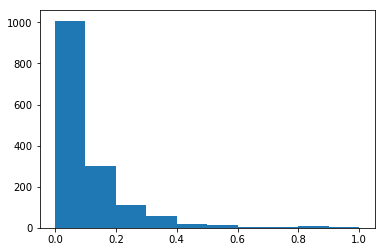

In [222]:
plt.hist(metrics_df.loc[texts_df[texts_df["obfuscation"] == "LPR"].index]["sum_vectors"], range=(0, 1))

(array([ 332.,  349.,  241.,  141.,   63.,   37.,   25.,   14.,   16.,    6.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

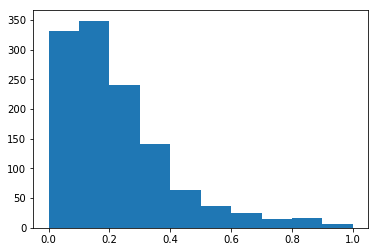

In [237]:
plt.hist(metrics_df.loc[texts_df[texts_df["obfuscation"] == "HPR"].index]["sum_vectors"], range=(0, 1))

(array([ 361.,  400.,  284.,  210.,  115.,  109.,   31.,   14.,   23.,   16.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

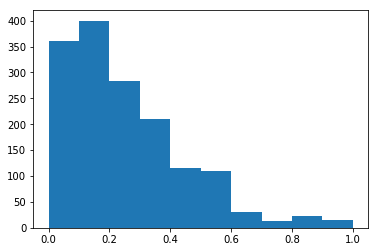

In [247]:
plt.hist(metrics_df.loc[texts_df[texts_df["obfuscation"] == "LPR"].index]["jaccard_vectors"], range=(0, 1))

Pairs covered by key metrics: 60.6%


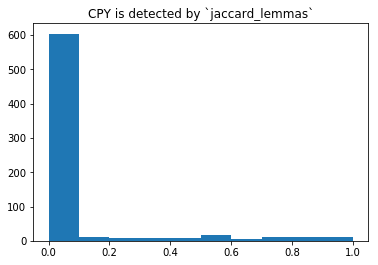

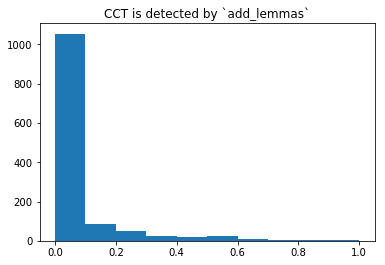

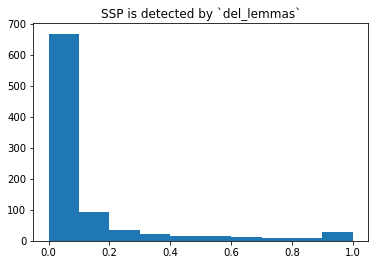

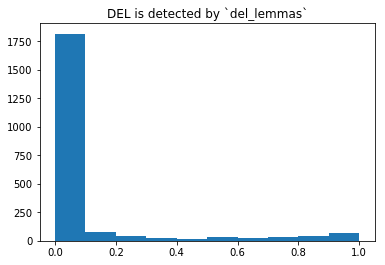

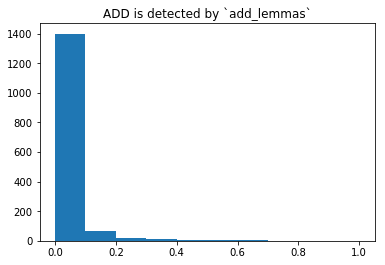

In [283]:
key_metrics = (("CPY", "jaccard_lemmas"),
               ("CCT", "add_lemmas"),
               ("SSP", "del_lemmas"),
               ("DEL", "del_lemmas"),
               ("ADD", "add_lemmas"))

obfuscations_covered = list(map(lambda p: p[0], key_metrics))
texts_covered_cnt = texts_df["obfuscation"].apply(lambda s: s in obfuscations_covered).sum()
print("Pairs covered by key metrics: %.1f%%" % (100 * (texts_covered_cnt / len(texts_df))))

for obfuscation_type, metric_name in key_metrics:
    plt.hist(metrics_df.loc[texts_df[texts_df["obfuscation"] == obfuscation_type].index][metric_name], range=(0, 1))
    plt.title("%s is detected by `%s`" % (obfuscation_type, metric_name))
    plt.show()

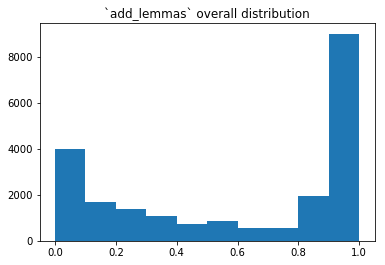

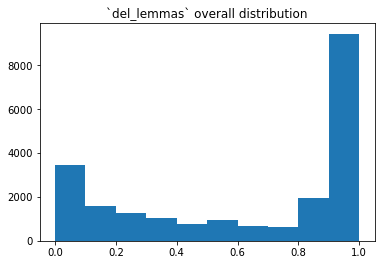

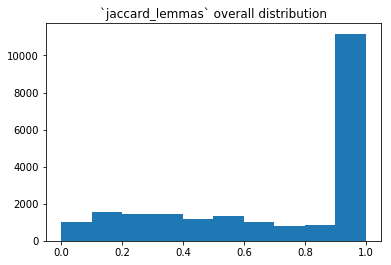

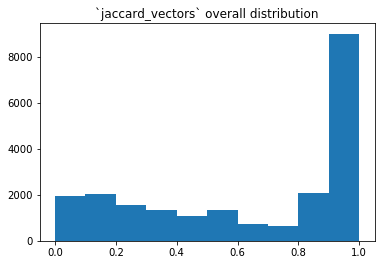

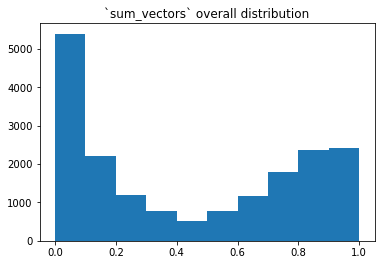

In [220]:
metrics_names = ("add_lemmas", "del_lemmas", "jaccard_lemmas", "jaccard_vectors", "sum_vectors")

for metric_name in metrics_names:
    plt.hist(metrics_df[metric_name].values, range=(0, 1))
    plt.title("`%s` overall distribution" % metric_name)
    plt.show()

---